# How much money can we save by cutting public sector wages?
We'll use marginal rates, so that we can protect those who don't earn that much.

This notebook is a mere rough estimation of how much we could potentially save. For a more precise result, we'd need to generate a Probability Density Function using a distribution that makes sense for each group, but that would need a bit more data to be achieved properly.

All data is from Brazil in 2019.


**Notes:** The source for any magic number you may encounter in this notebook is from ["IPEA's Atlas do Estado Brasileiro"](https://www.ipea.gov.br/atlasestado/), unless otherwise stated.

I've kept the original names of each group intact (Executivo, Judiciario and Legislativo). They respectively mean the Executive, Judiciary and Legislative branches.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

### Filtering and cleaning the dataset

In [2]:
df = pd.read_csv('9532-dados1.csv', sep = ';')

df = df[df['ano'] == 2019]

df.rename(columns={'poder': 'group'}, inplace = True)
df.rename(columns={'faixa': 'range'}, inplace = True)
df.rename(columns={'percentual': 'percentage'}, inplace = True)

df = df.iloc[:, 1:4]

df['group'] = df['group'].astype('category')
df['range'] = df['range'].astype('category')

### Generating wage numbers
For future calculations, I will consider that anyone who earns more than 30k as the following:

**Executivo:** 22 mil

**Legislativo:** 33 mil

**Judiciario:** 41.35 mil

In [3]:
df['meanWage'] = [1.4, (2.5 + 5)/2, (5 + 7.5)/2, (7.5 + 10)/2,
                    (10 + 12.5)/2, (12.5 + 15)/2, (15 + 17.5)/2, (17.5 + 20)/2,
                    (20 + 22.5)/2, (22.5 + 25)/2, (25 + 27.5)/2, (27.5 + 30)/2, 41.35]*3

df.loc[38, 'meanWage'] = 33 #fixing legislativo value
df.loc[12, 'meanWage'] = 22 #fixing executivo value

df['meanWage'] = df['meanWage'] * 1000 #re-scaling values
df.head()

,group,range,percentage,meanWage
0,Executivo,"< 2,5 mil",0.464444,1400.0
1,Executivo,"2,5 - 5 mil",0.302453,3750.0
2,Executivo,"5 - 7,5 mil",0.116305,6250.0
3,Executivo,"7,5 - 10 mil",0.049220,8750.0
4,Executivo,"10 - 12,5 mil",0.024077,11250.0


### Calculating population

A quick google search tells us that there are 10.89 million public sector workers in Brazil.

**Executivo: 10,023 thousand**

**Judiciário: 360.12 thousand**

**Legislativo: 304.29 thousand**

In [4]:
df.loc[df['group'] == 'Executivo', 'population'] = df['percentage'] * 10_023_000
df.loc[df['group'] == 'Judiciario', 'population'] = df['percentage'] * 360_120
df.loc[df['group'] == 'Legislativo', 'population'] = df['percentage'] * 304_290

df['population'] = df['population'].astype('int')

### Calculating marginal rates
We'll test with 2 different *marginal* rates tables to calculate how much money we can potentially save.

#### Soft cut
|Wage|Rate|
|---|---|
|Up to 3750 | 0% |
|3751 ~ 11250 | 4% |
|11251 ~ 21250|	8% |
|Above 21251| 12% |

#### Aggressive cut

|Wage|Rate|
|---|---|
|Up to 3750 | 3% |
|3751 ~ 11250 | 15% |
|11251 ~ 21250|	35% |
|Above 21251| 66% |

In [39]:
def marginalWageCut(df, rates=[0, 0, 0, 0]):  
    # For each row, we're going to add up the portions of the wage that fall into each bracket
    for idx, row in df.iterrows():
        wage = row['meanWage']
        newWage = 0
        
        if wage <= 3750:
            newWage += wage * (1 - rates[0])
        else:
            newWage += 3750 * (1 - rates[0])
        
        if wage > 3750 and wage <= 11250:
            newWage += (wage - 3750) * (1 - rates[1])
        elif wage > 11250:
            newWage += (11250 - 3750) * (1 - rates[1])
            
        if wage > 11250 and wage <= 21250:
            newWage += (wage - 11250) * (1 - rates[2])
        elif wage > 21250:
            newWage += (21250 - 11250) * (1 - rates[2])
            
        if wage > 21250:
            newWage += (wage - 21250) * (1 - rates[3])
        
        df.at[idx, 'newWage'] = newWage
    
    # Calculating how much we're saving | The sum of (Old - New) values
    grouped_Old = (df['population'] * df['meanWage']).groupby(df['group']).sum()
    grouped_New = (df['population'] * df['newWage']).groupby(df['group']).sum()
    
    totalSavings = 0
    
    for group, total in grouped_Old.items():
        groupedTotal = (grouped_Old[group] - grouped_New[group])
        print(f"{group} is saving R$ {groupedTotal:,.0f}")
        totalSavings += groupedTotal
    
    print(f"\nThis is equal to reducing total salary expenditure by {((totalSavings / grouped_Old.sum()) * 100).round(2)}%")
    print(f"Which is also equal to saving R${totalSavings * 12:,.0f} per year")
    print(f"Total yearly Cost is: R${grouped_New.sum() * 12:,.0f} \n")
    print(f"\nIn terms of GDP (2019), this equals to {((totalSavings * 12 / 7_250_000_000_000) * 100).round(2)}%")
    print(f"In terms of Total Government Expenditure (2019), this equals to {((totalSavings * 12 / 2_711_000_000_000) * 100).round(2)}%")
    
    
    
    return df.copy()

# Conclusion
As you can see below, this experiment would be impractical in reality.
Cutting wages is politically hard (even if it's relatively small).

So a Soft Cut wouldn't be worth it (it's total impact on Gov Budget would be around 0.03%).

And a Aggressive Cut would be significant, but far from miraculous.

To put these numbers in perspective, I'll link how Gov Budget looked like in 2019.

### Soft Cut

In [40]:
softCut = marginalWageCut(df, [.0,.04,.08,.12])

Executivo is saving R$ 674,333,750
Judiciario is saving R$ 182,658,520
Legislativo is saving R$ 55,439,500

This is equal to reducing total salary expenditure by 1.97%
Which is also equal to saving R$10,949,181,240 per year
Total yearly Cost is: R$545,905,686,960 


In terms of GDP (2019), this equals to 0.15%
In terms of Total Government Expenditure (2019), this equals to 0.4%


### Agressive Cut

In [41]:
aggCut = marginalWageCut(df, [.03,.15,.35,.66])

Executivo is saving R$ 3,533,405,324
Judiciario is saving R$ 824,363,856
Legislativo is saving R$ 265,298,058

This is equal to reducing total salary expenditure by 9.96%
Which is also equal to saving R$55,476,806,856 per year
Total yearly Cost is: R$501,378,061,344 


In terms of GDP (2019), this equals to 0.77%
In terms of Total Government Expenditure (2019), this equals to 2.05%


##### How much does the government spend in total with public workers?

In [43]:
Total_cost_of_public_sector_workers = marginalWageCut(df, [1,1,1,1])

Executivo is saving R$ 40,138,494,550
Judiciario is saving R$ 4,435,290,050
Legislativo is saving R$ 1,830,787,750

This is equal to reducing total salary expenditure by 100.0%
Which is also equal to saving R$556,854,868,200 per year
Total yearly Cost is: R$0 


In terms of GDP (2019), this equals to 7.68%
In terms of Total Government Expenditure (2019), this equals to 20.54%


<img src="https://auditoriacidada.org.br/wp-content/uploads/2020/05/Grafico-Orcamento-2019-html.jpg" style="height:500px" />

As you can see, while we could save theoretically up to 55.5 Billion BRL with an aggressive cut, amortization and interest on public debt alone is around 1 Trillion BRL

### Visualizing salaries, before and after

In [8]:
# Combine the dataframes to plot later
aggCut['type'] = 'Aggressive Cut'
softCut['type'] = 'Soft Cut'
df['type'] = 'No Cut (Original Wages)'

combined_df = pd.concat([aggCut, softCut, df], axis=0)

combined_df.reset_index(drop=True, inplace=True) # Without this, next line returns an error
combined_df.loc[combined_df['type'] == 'No Cut (Original Wages)', 'newWage'] = combined_df['meanWage']

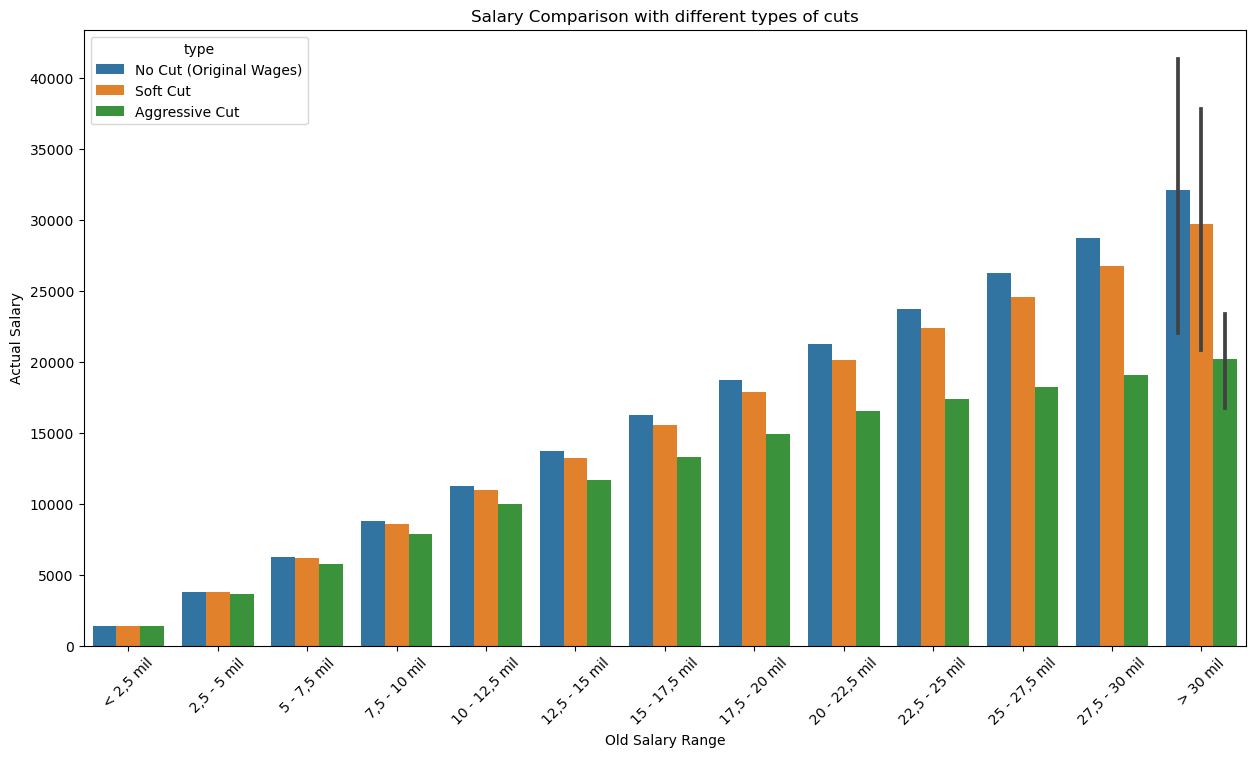

In [54]:
salary_order = ['< 2,5 mil', '2,5 - 5 mil', '5 - 7,5 mil', '7,5 - 10 mil', '10 - 12,5 mil', 
                '12,5 - 15 mil', '15 - 17,5 mil', '17,5 - 20 mil', '20 - 22,5 mil', '22,5 - 25 mil',
                '25 - 27,5 mil', '27,5 - 30 mil', '> 30 mil']

hue_order = ["No Cut (Original Wages)","Soft Cut", "Aggressive Cut"]

plt.figure(figsize=(15, 8))
sns.barplot(x='range',
            y='newWage',
            hue='type',
            hue_order = hue_order,
            order = salary_order,
            data=combined_df)
plt.title('Salary Comparison with different types of cuts')
plt.xlabel('Old Salary Range')
plt.ylabel('Actual Salary')
plt.xticks(rotation=45)
plt.show()

## Impact on different branches of Government

In [47]:
judc_df = combined_df[combined_df['group'] == 'Judiciario']
exec_df = combined_df[combined_df['group'] == 'Executivo']
legs_df = combined_df[combined_df['group'] == 'Legislativo']

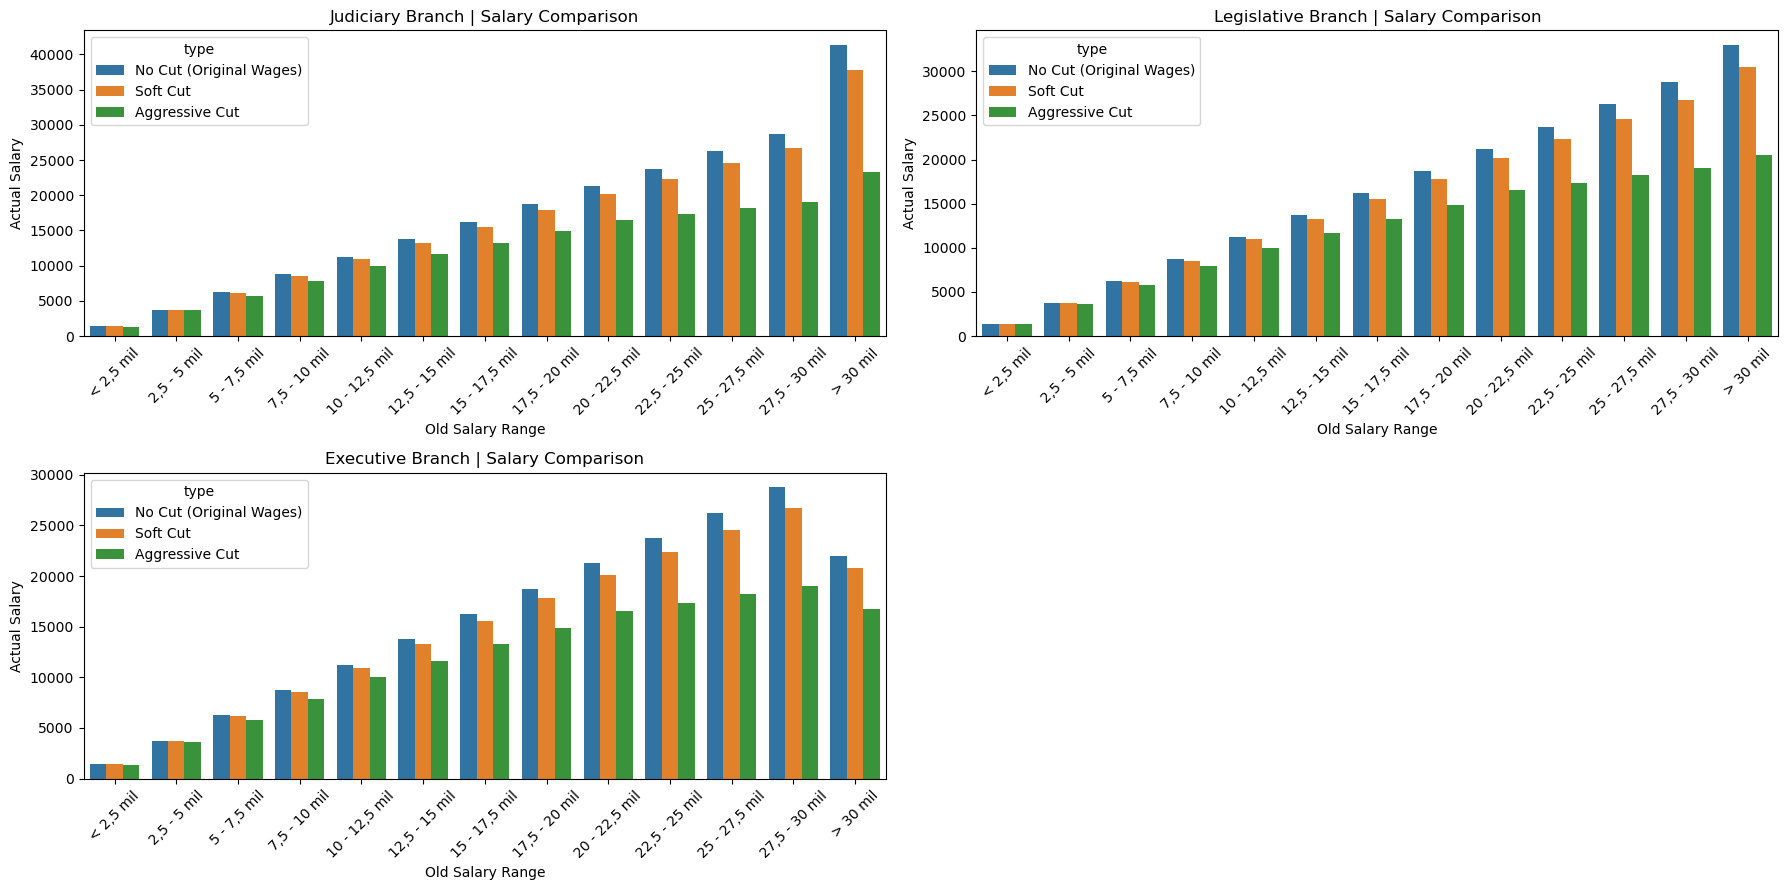

In [58]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 9))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plotting the first graph (Judiciary Branch)
sns.barplot(x='range',
            y='newWage',
            hue='type',
            hue_order=hue_order,
            order=salary_order,
            data=judc_df,
            ax=axes[0])
axes[0].set_title('Judiciary Branch | Salary Comparison')
axes[0].set_xlabel('Old Salary Range')
axes[0].set_ylabel('Actual Salary')
axes[0].tick_params(axis='x', rotation=45)

# Plotting the second graph (Legislative Branch)
sns.barplot(x='range',
            y='newWage',
            hue='type',
            hue_order=hue_order,
            order=salary_order,
            data=legs_df,
            ax=axes[1])
axes[1].set_title('Legislative Branch | Salary Comparison')
axes[1].set_xlabel('Old Salary Range')
axes[1].set_ylabel('Actual Salary')
axes[1].tick_params(axis='x', rotation=45)

# Plotting the third graph (Executive Branch)
sns.barplot(x='range',
            y='newWage',
            hue='type',
            hue_order=hue_order,
            order=salary_order,
            data=exec_df,
            ax=axes[2])
axes[2].set_title('Executive Branch | Salary Comparison')
axes[2].set_xlabel('Old Salary Range')
axes[2].set_ylabel('Actual Salary')
axes[2].tick_params(axis='x', rotation=45)

# Remove the fourth (unused) subplot
axes[3].remove()

plt.tight_layout()
plt.show()

As we can see, the blunt of the cut would affect the Judiciary and Legislative more, as compared to the Executive branch.

## Final Note:

Again, this notebook is a mere rough estimation of how much we could potentially save. In practice, the numbers would differ because of:
- Technical reasons (cited in the intro)
- Political reasons: like excluding certain categories in the cut
- Accounting reasons: the original data may not include "pendants/benefits" that some privileged categories have (specially in the judiciary sector, judges for instance). Such benefits often are higher than the actual 'wage' they receive.

In [10]:
###



















###